In [1]:
import potpourri3d as pp3d
import polyscope as ps
import numpy as np
import pymeshlab

#V, F = pp3d.read_mesh("simple_geom.stl")

ms = pymeshlab.MeshSet()
#ms.load_new_mesh('spot_triangulated.obj')
#mesh = pymesh.form_mesh(V,F)
#print(mesh)

In [2]:
V = np.array([[0,0,0],
            [0,1,0],
            [1,0,0],
            [1,1,-0.25]])
F = np.array([[0,2,1],
             [1,2,3]])
m = pymeshlab.Mesh(V, F)

In [3]:
n = m.face_normal_matrix()
n

array([[0.        , 0.        , 1.        ],
       [0.23570226, 0.23570226, 0.94280904]])

In [4]:

def find_rot(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [5]:
x = np.cross(n[1],(0,1,0))
xs = np.full_like(V,x)
xs

array([[-0.94280904,  0.        ,  0.23570226],
       [-0.94280904,  0.        ,  0.23570226],
       [-0.94280904,  0.        ,  0.23570226],
       [-0.94280904,  0.        ,  0.23570226]])

In [6]:
def find_intersection(p1,vec1,p2,vec2, tol= 1e-6):
    if vec2[1] ==0:
        p1,vec1,p2,vec2 = p2,vec2,p1,vec1
    a = (p2[0]+(vec2[0]*p1[1]-vec2[0]*p2[1])/vec2[1]-p1[0]) / (vec1[0] - vec2[0]*vec1[1]/vec2[1])
    b = (p1[1]+ a*vec1[1]-p2[1])/vec2[1]
    p_int1 = (p1[0]+ a*vec1[0],p1[1]+ a*vec1[1],p1[2]+ a*vec1[2])
    assert abs((p1[2]+ a*vec1[2])-(p2[2]+ b*vec2[2])) < tol, "Lines do not intersect in 3D space"
    return p_int1

geopath = []
vecs = []
seedP = (0.1, 0, 0)
seedVec = (-0.9, 0.1, 0.1)
#Get seed vector to align with first face:
vec = np.cross(seedVec,n[0])
p = seedP

geopath.append(p)
vecs.append(vec)

x = np.cross(n[0],n[1])
p = find_intersection(p,vec,V[2],x)
geopath.append(p)

r = find_rot(n[0],n[1])
vec = np.dot(r,vec)
vecs.append(vec)

x = np.cross(n[1],(0,1,0))
print(x)
p = find_intersection(p,vec,V[3],x)#In case of vector with 0 value in y, have to reverse order (need to think about why)
geopath.append(p)

r = find_rot(n[1],(0,1,0))
vec = np.dot(r,vec)
vecs.append(vec)


geopath = np.array(geopath)
vecs = np.array(vecs)

[-0.94280904  0.          0.23570226]


In [7]:
# Initialize polyscope
ps.init()

### Register a point cloud
# `my_points` is a Nx3 numpy array
#ps.register_point_cloud("my points", my_points)

### Register a mesh
# `verts` is a Nx3 numpy array of vertex positions
# `faces` is a Fx3 array of indices, or a nested list
ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)

# Add a scalar function and a vector function defined on the mesh
# vertex_scalar is a length V numpy array of values
# face_vectors is an Fx3 array of vectors per face
#ps.get_surface_mesh("my mesh").add_scalar_quantity("logmap0", logmap[:,0], defined_on='vertices', cmap='rainbow')
#ps.get_surface_mesh("my mesh").add_scalar_quantity("logmap1", logmap[:,1], defined_on='vertices', cmap='rainbow')
#ps.get_surface_mesh("my mesh").add_vector_quantity("X", basisX, defined_on='vertices', color=(0.2, 0.5, 0.5))
#ps.get_surface_mesh("my mesh").add_vector_quantity("Y", basisY, defined_on='vertices', color=(1, 0.5, 0.5))
#ps.get_surface_mesh("my mesh").add_vector_quantity("Z", basisN, defined_on='vertices', color=(0, 1, 0.5))

ps.get_surface_mesh("my mesh").add_vector_quantity("normals", n, defined_on='faces', color=(1, 0.5, 0.5))
ps_cloud = ps.register_point_cloud("vertices", V)
ps_cloud = ps.get_point_cloud("vertices").add_vector_quantity("xs", xs, color=(1, 1, 0.5))

ps_cloud = ps.register_point_cloud("geopoints", geopath)
ps_cloud = ps.get_point_cloud("geopoints").add_vector_quantity("vecs", vecs, color=(1, 1, 0.5), enabled = True)

# View the point cloud and mesh we just registered in the 3D UI
ps_net = ps.register_curve_network("Geodesic", geopath, 'line')
ps.show()

In [53]:
ms.add_mesh(m)

In [54]:
ms.save_current_mesh('twoTriangles.stl')

In [2]:
path_solver = pp3d.EdgeFlipGeodesicSolver(V,F) # shares precomputation for repeated solves
path_pts = path_solver.find_geodesic_path_poly([110,1968,2124,1420,345,2595,2738,2754])
# path_pts is a Vx3 numpy array of points forming the path
print(path_pts)

[[-0.313132   -0.399051    0.881192  ]
 [-0.33420645 -0.37227846  0.83330874]
 [-0.33941156 -0.34964909  0.78576437]
 [-0.34041885 -0.34524585  0.77651113]
 [-0.34082487 -0.33527081  0.75495885]
 [-0.34040796 -0.3178194   0.71715309]
 [-0.34101078 -0.31022796  0.70065635]
 [-0.34331168 -0.2914056   0.65968893]
 [-0.34808497 -0.27403984  0.62165259]
 [-0.35007459 -0.26659343  0.60534587]
 [-0.3535729  -0.25418705  0.5781689 ]
 [-0.35702262 -0.24178203  0.5509974 ]
 [-0.35951859 -0.23276933  0.53125692]
 [-0.36365051 -0.2161988   0.49497564]
 [-0.36666006 -0.20462015  0.46962467]
 [-0.36998044 -0.18961851  0.43676873]
 [-0.37078737 -0.18669858  0.43038019]
 [-0.37241461 -0.1806878   0.41722732]
 [-0.37530591 -0.16807073  0.38955681]
 [-0.37656497 -0.16212235  0.37649206]
 [-0.37924157 -0.14893633  0.34750905]
 [-0.38229173 -0.13412629  0.31496466]
 [-0.38276294 -0.12989116  0.30559106]
 [-0.3838714  -0.1207426   0.28535561]
 [-0.38448796 -0.11046931  0.26247162]
 [-0.38474518 -0.10635478

In [87]:
# = Stateful solves
P = V
solver = pp3d.PointCloudHeatSolver(P)

# Compute the geodesic distance to point 4
dists = solver.compute_distance(657)

# Extend the value `0.` from point 12 and `1.` from point 17. Any point 
# geodesically closer to 12. will take the value 0., and vice versa 
# (plus some slight smoothing)
ext = solver.extend_scalar([657, 357], [0.,1.])

# Get the tangent frames which are used by the solver to define tangent data
# at each point
basisX, basisY, basisN = solver.get_tangent_frames()

# Parallel transport a vector along the surface
# (and map it to a vector in 3D)
sourceP = 1855
extv = solver.transport_tangent_vector(sourceP, [6., 6.])
ext3D = extv[:,0,np.newaxis] * basisX +  extv[:,1,np.newaxis] * basisY

# Compute the logarithmic map
logmap = solver.compute_log_map(sourceP)

In [85]:
logmap[0,:]

array([-0.2801006 ,  0.91413622])

In [58]:
ext


array([0., 0., 0., ..., 0., 0., 0.])

Geodesic Line 0 | DONE
Geodesic Line 1 | DONE
Geodesic Line 2 | DONE
Geodesic Line 3 | DONE
Geodesic Line 4 | DONE
Geodesic Line 5 | DONE
Geodesic Line 6 | DONE
Geodesic Line 7 | DONE
Geodesic Line 8 | DONE
Geodesic Line 9 | DONE
Geodesic Line 10 | DONE
Geodesic Line 11 | DONE
Geodesic Line 12 | DONE
Geodesic Line 13 | DONE
Geodesic Line 14 | DONE
Geodesic Line 15 | DONE
Geodesic Line 16 | DONE
Geodesic Line 17 | DONE
Geodesic Line 18 | DONE
Geodesic Line 19 | DONE
Geodesic Line 20 | DONE
Geodesic Line 21 | DONE
Geodesic Line 22 | DONE
Geodesic Line 23 | DONE
Geodesic Line 24 | DONE
Geodesic Line 25 | DONE
Geodesic Line 26 | DONE
Geodesic Line 27 | DONE


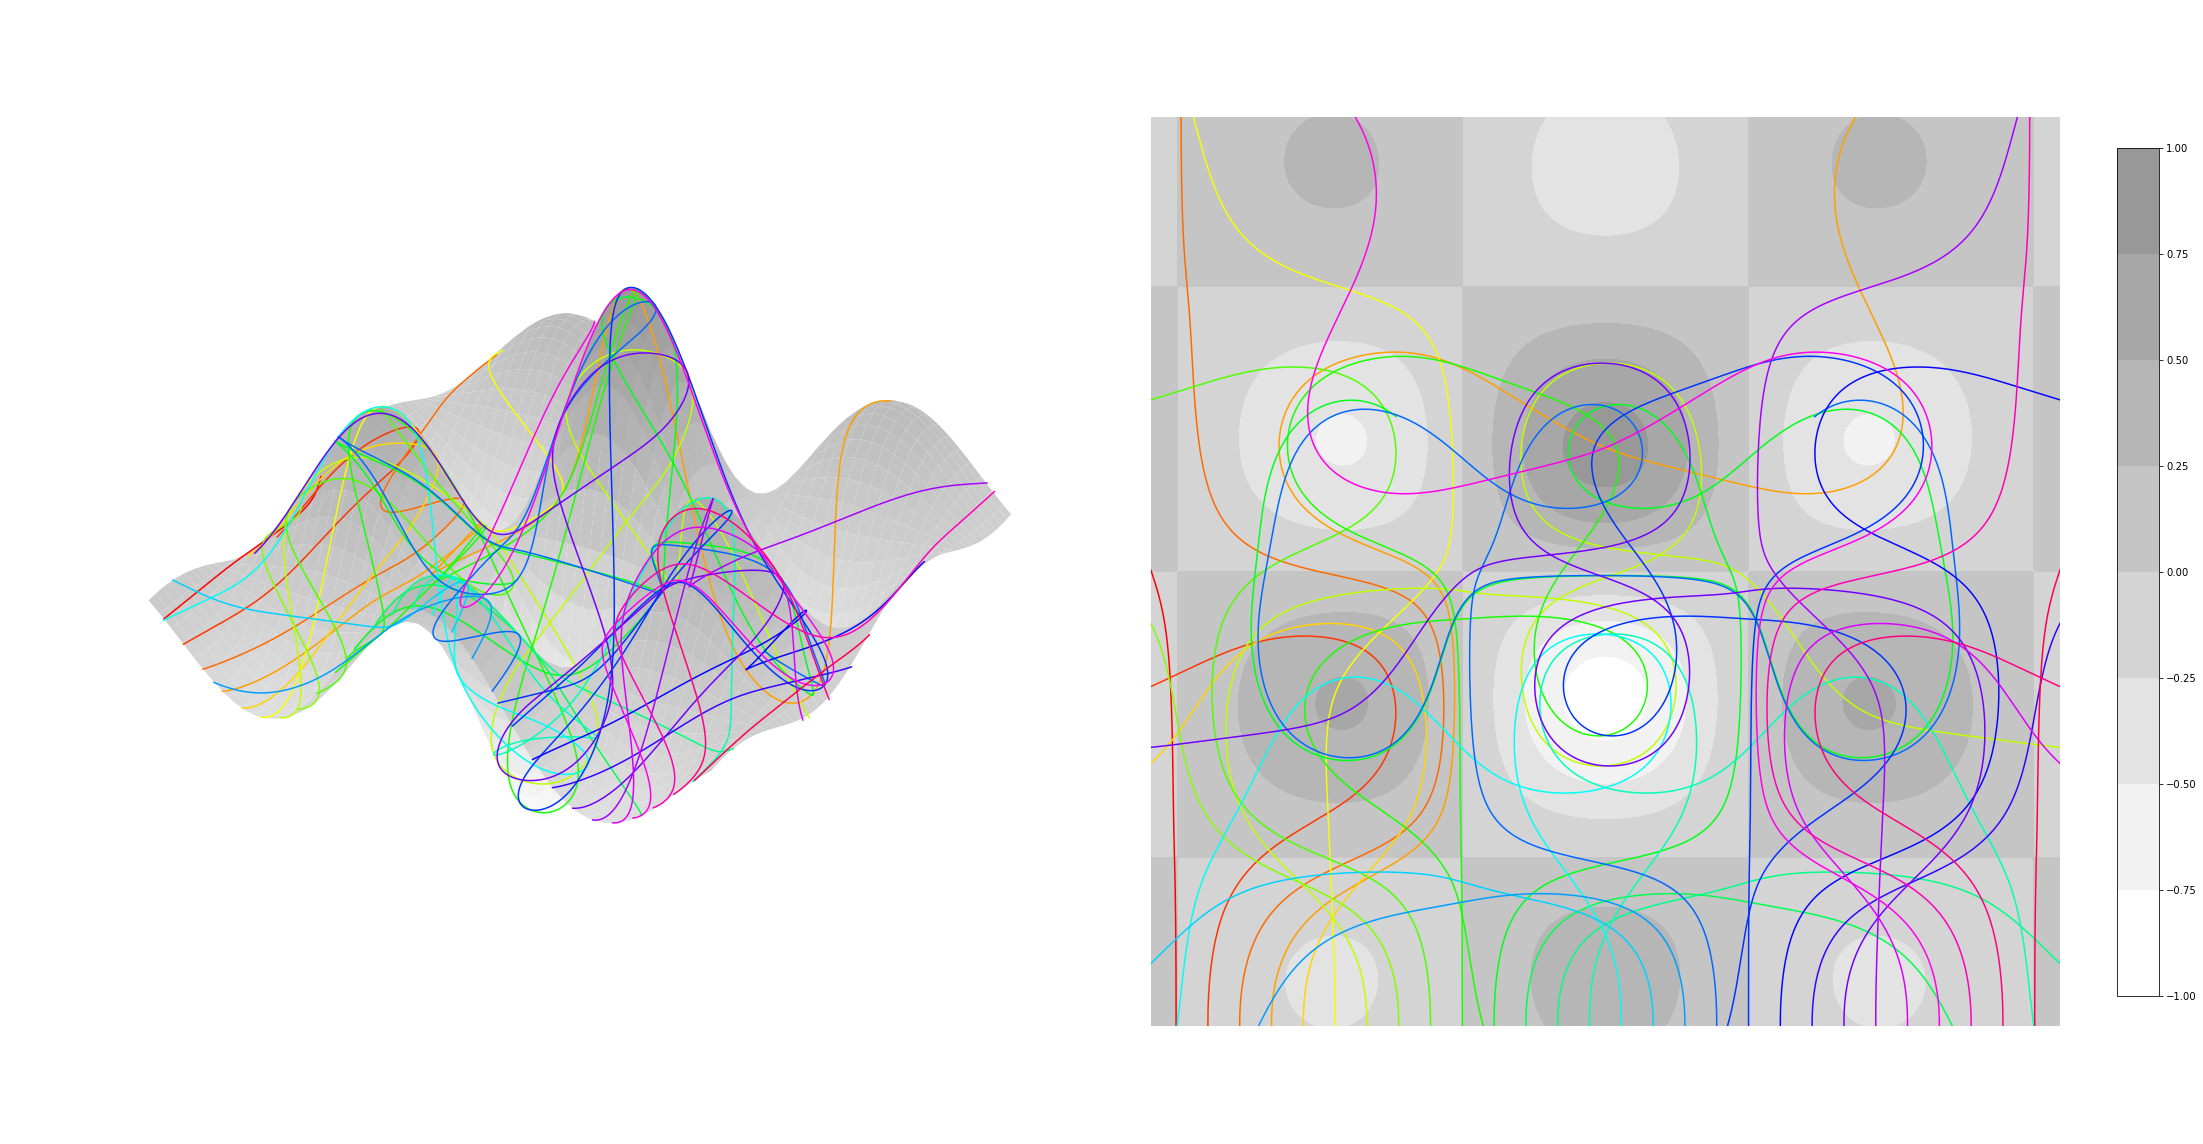

In [16]:
"""
PYTHON GEODESIC LINES SCRIPT
Inspired by http://www.physikdidaktik.uni-karlsruhe.de/software/geodesiclab/a3.html
From a discussion by Math Stunned on Stackoverflow:
https://stackoverflow.com/questions/60106732/how-to-plot-geodesic-curves-on-a-surface-embedded-in-3d
"""

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits import mplot3d


class Canvas:
    """
    The canvas area containing the surface function on which we want to compute geo-lines.
    """

    def __init__(self, f, xmin=-1, xmax=1, ymin=-1, ymax=1, smoothness=200):

        self.f = f  # f(x,y) function defining the 'world' landscape

        self.xmin = xmin    # lower x-axis limit of the grid on which to evaluate the function
        self.xmax = xmax    # higher x-axis limit of the grid on which to evaluate the function
        self.ymin = ymin    # lower y-axis limit of the grid on which to evaluate the function
        self.ymax = ymax    # higher y-axis limit of the grid on which to evaluate the function

        self.smoothness = smoothness    # number of points over which to evaluate the function

    def dfdx(self, x, y):
        """
        Approximate derivative of the function with respect to x, evaluated at the point (x,y)
        args:
            x:          x coordinate of the point
            y:          y coordinate of the point
        returns: df/dx
        """

        epsilon = 0.0001
        return (self.f(x + epsilon, y) - self.f(x - epsilon, y)) / (2 * epsilon)

    def dfdy(self, x, y):
        """
        Approximate derivative of the function with respect to y, evaluated at the point (x,y)
        args:
            x:          x coordinate of the point
            y:          y coordinate of the point
        returns: df/dy
        """

        epsilon = 0.0001
        return (self.f(x, y + epsilon) - self.f(x, y - epsilon)) / (2 * epsilon)

    def fn(self, x, y):
        """
         Unit normal vector, evaluated at the point (x,y)
         args:
             x:          x coordinate of the point
             y:          y coordinate of the point
         returns: unit normal vector
         """

        n = np.array([self.dfdx(x, y), self.dfdy(x, y), -1])
        mag = np.sqrt(n[0] ** 2 + n[1] ** 2 + 1)

        return n / mag


class GeoLine:
    """
    The geodesic line object and all its properties
    """

    def __init__(self, canvas, x0, y0, dx0=0, dy0=0.05, step_size=0.01):

        self.canvas = canvas    # the Canvas object on which the geo-line will be evaluated

        self.x = np.array([x0])     # array of x coordinates of the geo-line trajectory
        self.y = np.array([y0])     # array of y coordinates of the geo-line trajectory
        self.z = self.canvas.f(self.x, self.y)  # array of z coordinates of the geo-line trajectory

        self.init_step(x0, y0, dx0, dy0, step_size)     # do arbitrary initialisation step in one direction

        self.finished = False   # whether the whole geo-line trajectory has been calculated

    def init_step(self, x, y, dx, dy, step_size):
        """
        Perform a first initialisation step to prepare trajectory for iterative algorithm
        args:
            x:          current geo-line x position
            y:          current geo-line y position
            dx:         initialisation step in the x direction
            dy:         initialisation step in the y direction
            step_size:  hyperparameter regulating scale of initialisation step
        returns:    updated geo-line position arrays
        """

        eta = step_size / np.sqrt(dx ** 2 + dy ** 2)

        self.x = np.append(self.x, x + eta * dx)
        self.y = np.append(self.y, y + eta * dy)
        self.z = np.append(self.z, self.canvas.f(self.x[-1], self.y[-1]))

    def is_out_bounds(self, x, y):
        """
         Checks if a given point is outside of the canvas area.
         args:
             x:      x coordinate of the point
             y:      y coordinate of the point
         returns: updated geo-line status
         """

        if x < self.canvas.xmin or x > self.canvas.xmax or y < self.canvas.ymin or y > self.canvas.ymax:
            self.finished = True

    def step_next(self):
        """
        Advances the geo-line by one step.
        Calculation based on geo-line position at time t and at time (t-1)
        returns: updated geo-line position arrays and updated .finished status
        """

        # Current position
        xt = self.x[-1]
        yt = self.y[-1]
        zt = self.canvas.f(xt, yt)

        # Previous position
        xtm1 = self.x[-2]
        ytm1 = self.y[-2]
        ztm1 = self.canvas.f(xtm1, ytm1)

        # Symmetric position wrt current position
        # i.e. position such that position at time t is the midpoint between the position at (t-1) and this position
        xp = xt + (xt - xtm1)  # read as 'x+'
        yp = yt + (yt - ytm1)
        zp = zt + (zt - ztm1)

        # Difference between predicted value of f and actual value of f at the symmetric point
        dz = zp - self.canvas.f(xp, yp)
        # Normal at current position
        n = self.canvas.fn(xt, yt)
        # Correction factor
        gamma = dz * n[2]

        # Next position (correcting the 'symmetric' guess by a factor gamma*n)
        xtp1 = xp - gamma * n[0]  # read as 'x_{t+1}'
        ytp1 = yp - gamma * n[1]

        # Update geo-line trajectory with the new position
        self.x = np.append(self.x, xtp1)
        self.y = np.append(self.y, ytp1)
        self.z = np.append(self.z, self.canvas.f(xtp1, ytp1))

        # Check if new step is out of bounds, then geo-line is finished
        self.is_out_bounds(xtp1, ytp1)


def my_func(x, y):
    """
    Landscape on which to calculate geodesic lines.
    args:
        x:      x coordinate of the point
        y:      y coordinate of the point
    returns: f(x,y)
    """

    # Flat Bump
    #z = .03 / (.1 + x * x + y * y)

    # Medium Bump
    #z = .3 / (.3 + x**2 + y**2)

    # High bump
    #z = .2 / (.1 + x**2 + y**2)

    # Crater
    #z = (x**2 + y**2) * (1 - x**2 - y**2)

    # Bump and dimple
    #z = .1 / (.1 + (y - .5)**2 + x**2) - .1 / (.1 + (y + .5)**2 + x**2)

    # Hilly Landscape
    z = np.sin(5*y) * np.cos(5*x) / 2 / (.5 + x**2 + y**2)

    return z


if __name__ == "__main__":

    # ------------------------------------------------------------------------------------------------------------------
    # ALGORITHM
    # ------------------------------------------------------------------------------------------------------------------

    max_num_iter = 1000     # max number of points per line
    num_lines = 28          # number of geodesic lines to draw

    # -- SANDBOX INITIALIZATION
    # -- The surface on which we want to calculate geo-lines

    sandbox = Canvas(my_func)  # can use any arbitrary function

    # -- CALCULATE GEO-LINES

    buffer_x, buffer_y, buffer_z = [], [], []  # initialize containers for geo-line trajectories

    # creating multiple uniformly spaced geo-lines all starting on the canvas y-edge
    for (line_idx, x_start) in enumerate(np.linspace(sandbox.xmin+0.055, sandbox.xmax-0.055, num_lines)):

        # Initialize geo-line, evolving in our sandbox
        geoline = GeoLine(sandbox, x0=x_start, y0=sandbox.ymin)

        # Propagate geo-line for N time-steps
        for i in range(1, max_num_iter):

            if geoline.finished:
                break
            else:
                geoline.step_next()

        print(f"Geodesic Line {line_idx} | DONE")

        buffer_x.append(geoline.x), buffer_y.append(geoline.y), buffer_z.append(geoline.z)  # update buffers

    # ------------------------------------------------------------------------------------------------------------------
    # PLOTTING
    # ------------------------------------------------------------------------------------------------------------------

    # -- PLOT SANDBOX:
    fig = plt.figure(figsize=(32, 16))

    x = np.linspace(sandbox.xmin, sandbox.xmax, sandbox.smoothness)
    y = np.linspace(sandbox.ymin, sandbox.ymax, sandbox.smoothness)
    X, Y = np.meshgrid(x, y)
    Z = sandbox.f(X, Y)

    # ---- 3D SANDBOX
    ax3 = fig.add_subplot(1, 2, 1, projection='3d')
    ax3.set_axis_off()

    surf3 = ax3.plot_surface(X, Y, Z, cmap='binary', vmin=np.min(Z), vmax=4 * np.max(Z))

    # ---- 2D SANDBOX
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_aspect('equal')
    ax2.set_axis_off()

    surf2 = ax2.contourf(X, Y, Z, cmap='binary', vmin=np.min(Z), vmax=4 * np.max(Z))
    cb = fig.colorbar(surf2, shrink=0.75)

    # -- PLOT GEO-LINES
    cmap = cm.get_cmap('hsv')  # decide which colormap to use for the geodesic lines
    for i in range(num_lines):

        ax2.plot(buffer_x[i], buffer_y[i], c=cmap(i / num_lines), zorder=3)  # Plot 2D trajectory
        ax3.plot(buffer_x[i], buffer_y[i], buffer_z[i], c=cmap(i / num_lines), zorder=3)  # Plot 3D trajectory

    plt.xlim(sandbox.xmin, sandbox.xmax)
    plt.ylim(sandbox.ymin, sandbox.ymax)

    plt.tight_layout()
    plt.show()